In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import IPython.display as display
import matplotlib as mpl

In [23]:
# convert tensor to image
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype= np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] ==1
    tensor = tensor[0]
  
  return PIL.Image.fromarray(tensor)

In [24]:
# load image
def load_image(path_image):
  # read image file
  img = tf.io.read_file(path_image)
  # convert to 3 channels
  img = tf.image.decode_image(img , channels=3)
  # convert to type float32
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = img[tf.newaxis,:]
  return img


In [25]:
# show image
def show_image(img, title = None):
  if len(img.shape) > 3:
    img = tf.squeeze(img, axis=0)
  plt.imshow(img)
  if title :
    plt.title(title)

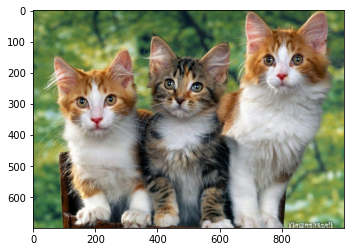

In [26]:
path_img = '/content/drive/MyDrive/AI_Insight/style_transfer/data/hinh-3-con-meo.jpg'
img= load_image(path_img)
show_image(img)
#img.shape

In [27]:
# get layer
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  # squeez weights
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  if len(layer_names) == 1:
    model = tf.keras.Model([vgg.input], [outputs])
  else:
    model = tf.keras.Model([vgg.input], outputs)

  return model

In [28]:
# gram matrix for style loss
def gram_matrix(input_tensor):
  # function total gram matrix
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations= tf.cast(input_shape[1] * input_shape[2], tf.float32)
  return result / num_locations

In [29]:
# class create content and style model

class ContentStyleModel(tf.keras.models.Model):
  def __init__(self, content_layer, style_layer):
    super(ContentStyleModel, self).__init__()
    self.content_layer = content_layer
    self.style_layer = style_layer
    self.vgg_content = vgg_layers(content_layer)
    self.vgg_style = vgg_layers(style_layer)
    self.vgg_content.trainable = False
    self.vgg_style.trainable = False

  def __call__(self, inputs_content, input_style):
    # scale inputs from[0-1] to [0-255]
    inputs_content = inputs_content * 255
    input_style = input_style * 255
    # scale data for vgg19
    preprocess_input_content = tf.keras.applications.vgg19.preprocess_input(inputs_content)
    preprocess_input_style = tf.keras.applications.vgg19.preprocess_input(input_style)

    # dict for content feature
    content_outputs = self.vgg_content(preprocess_input_content)
    content_dict = {content_name : value
                    for content_name , value in zip(self.content_layer, content_outputs)}

    # dict for style fearure
    style_outputs = self.vgg_style(preprocess_input_style)
    style_outputs = [gram_matrix(input_tensor) for input_tensor in style_outputs] # ứng với mỗi feature tính gram_matrix
    style_dict ={style_name : value
                 for style_name, value in zip(self.style_layer, style_outputs)}

    return content_dict, style_dict   

In [30]:
# create loss
def content_style_loss(content_outputs, style_outputs, content_target, style_target):
  style_weight= 10
  content_weight = 1e+4
  # loss content
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_target[name])**2) for name in content_outputs.keys()])
  content_loss *= content_weight / len(content_outputs)

  # loss style
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_target[name])**2) for name in style_outputs.keys()])
  style_loss *= style_weight / len(style_outputs)

  # total loss
  loss = content_loss + style_loss
  #print(len(content_outputs))
  return loss

In [31]:
# cale trong khoảng 0-1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [32]:
# gradient and optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#@tf.function()
def gradient_step(image_output,feature_content_target, feature_style_target, style_layer, content_layer ):
  #contentstyle = ContentStyleModel(content_layer, style_layer)
  with tf.GradientTape() as tape:
    contentstyle = ContentStyleModel(content_layer, style_layer)
    content_outputs,style_outputs = contentstyle(image_output, image_output)
    loss = content_style_loss(content_outputs,style_outputs,feature_content_target,feature_style_target)
    #print(loss)

  grad = tape.gradient(loss, image_output)
  opt.apply_gradients([(grad, image_output)])
  image_output.assign(clip_0_1(image_output))
  #return t

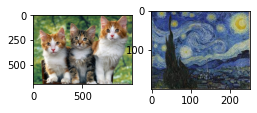

In [33]:
# load content image and style image
path_content_image = '/content/drive/MyDrive/AI_Insight/style_transfer/data/hinh-3-con-meo.jpg'
path_style_image ='/content/drive/MyDrive/AI_Insight/style_transfer/data/starrynight.png'
#path= '/content/drive/MyDrive/AI_Insight/style_transfer/out/at_17.png'
content_image = load_image(path_content_image)
style_image = load_image(path_style_image)
plt.subplot(1,3,1)
show_image(content_image)
plt.subplot(1,3,2)
show_image(style_image)
#out_image= load_image(path)
#plt.subplot(1,3,3)
#show_image(out_image)

In [18]:
# tạo output image
image_output = tf.Variable(tf.random.uniform(content_image.shape, minval=0, maxval=1))
print(image_output.shape)
type(image_output)

(1, 700, 1000, 3)


tensorflow.python.ops.resource_variable_ops.ResourceVariable

In [34]:
path='/content/drive/MyDrive/AI_Insight/style_transfer/out/at_23.png'
image_output = load_image(path)
print(image_output.shape)
print(type(image_output))
image_output = image_output / 255
image_output = tf.Variable(image_output)
print(type(image_output))

(1, 700, 1000, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


In [39]:
print(type(image_output))

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


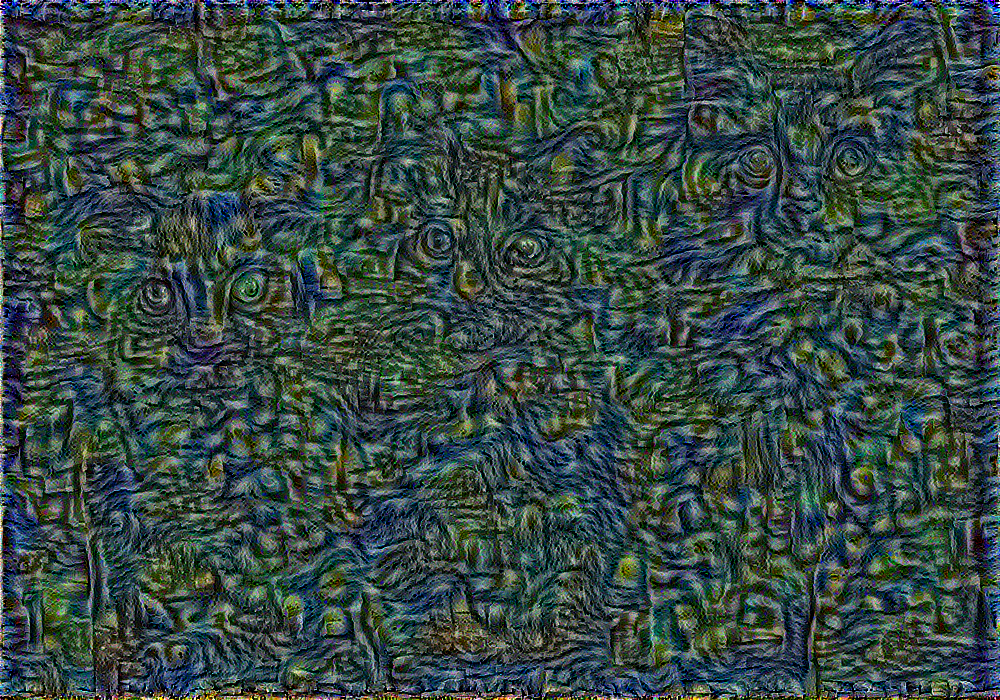

Train step: 200
...........................................

KeyboardInterrupt: ignored

In [40]:
# trainning
import time
start = time.time()
epochs = 35
style_layer =['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
content_layer =['block4_conv1', 'block5_conv1']

extracfeature = ContentStyleModel(content_layer,style_layer)
feature_content_target, feature_style_target = extracfeature(content_image ,style_image)
print(len(feature_content_target))
print(len(feature_style_target))
step = 0
steps_per_epoch = 100
for i in range(24,epochs):
  for j in range(steps_per_epoch):
    step += 1
    gradient_step(image_output,feature_content_target,feature_style_target,style_layer,content_layer)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image_output))
  print("Train step: {}".format(step))
  fname = '/content/drive/MyDrive/AI_Insight/style_transfer/out/at_%d.png' % (i+1)
  mpl.image.imsave(fname, image_output[0].numpy())
  
end = time.time()
print("Total time: {:.1f}".format(end-start))
  

In [ ]:
a = tf.add_n([4,7,8])
b=a*3
print(a)

tf.Tensor(19, shape=(), dtype=int32)


In [ ]:
1e+2

100.0